# B regressor final training

## Import

### Import modules

In [1]:
from __future__ import division ,print_function

import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge, GaussianDropout
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model
from keras import regularizers
from keras import backend as K

import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = [260, 270, 280, 300, 320, 500, 550, 600 ,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 9762 signal events and 168053 background events
177815 events in total


## Configure data

### Create development and validation samples

In [3]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)


### Move to cartesian coordinates

In [4]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

### Specify variables

In [5]:

genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]


In [6]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]

other = [var for var in trainFeatures for x in ['prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0',

In [7]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
b1Features = [var for var in trainFeatures if (str.startswith(var, "b_1"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in pTEtaPhi + recoFeatures + hlFeatures + b1Features]

In [8]:
set0 = [var for var in fsFeatures if var not in epFeatures]   
set1 = [var for var in fsFeatures]  
set2 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + epFeatures] + ['hl_mT']
set3 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']
set4 = ['b_0_mass', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E',
        'mPT_px', 'mPT_py',
        'h_bb_E',
        't_0_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E',
        't_1_mass', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E',
        'hl_mT',
        'h_tt_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E',
        'diH_E', 'diH_|p|', 'diH_mass']

## Specify options

In [ ]:
regTrainFeatures = list(set4)
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 5
ensembleMode = 'loss'
regTargetFeatures = ['gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])

In [10]:
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3705 events for training, 174101 events for validation


### Split data

In [11]:
regTrainFeatures0 = list(regTrainFeatures)
regTrainFeatures1 = list(regTrainFeatures)
for i in range(len(regTrainFeatures1)):
    if "b_0" in regTrainFeatures1[i]:
        regTrainFeatures1[i] = regTrainFeatures1[i][0:regTrainFeatures1[i].find("b_0")] + "b_1" + regTrainFeatures1[i][regTrainFeatures1[i].find("b_0")+3:]
regTargetFeatures0 = list(regTargetFeatures)
regTargetFeatures1 = list(regTargetFeatures)
for i in range(len(regTargetFeatures1)):
    if "b_0" in regTargetFeatures1[i]:
        regTargetFeatures1[i] = regTargetFeatures1[i][0:regTargetFeatures1[i].find("b_0")] + "b_1" + regTargetFeatures1[i][regTargetFeatures1[i].find("b_0")+3:]
print(regTargetFeatures0)
print(regTargetFeatures1)

['gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz']
['gen_b_1_px', 'gen_b_1_py', 'gen_b_1_pz']


In [748]:
X_reg_0 = devData[devData.gen_target == 1][regTrainFeatures0].values.astype(theano.config.floatX)         
X_reg_1 = devData[devData.gen_target == 1][regTrainFeatures1].values.astype(theano.config.floatX)
y_reg_0 = devData[devData.gen_target == 1][regTargetFeatures0].values.astype(theano.config.floatX)
y_reg_1 = devData[devData.gen_target == 1][regTargetFeatures1].values.astype(theano.config.floatX)





## Define regressor

In [749]:
compileArgs = [None,None]
compileArgs[0] = {'loss' : 'mse', 'optimizer' : 'nadam'}
compileArgs[1] = {'loss' : 'mse', 'optimizer' : 'nadam'}
def getRegressor(j):
    if(j == 0):
        regModel = Sequential()

        regModel.add(Dense(50, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        #regModel.add(GaussianDropout(0.3))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(50, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.1))
        regModel.add(Dense(60, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.1))
        regModel.add(Dense(70, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.1))
        #regModel.add(Dense(200, kernel_initializer='he_normal', 
        #                   activation='selu'))
        #regModel.add(GaussianNoise(1))
        #regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        #regModel.add(Dropout(0.2))
    if(j == 1):
        regModel = Sequential()

        regModel.add(Dense(70, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        #regModel.add(GaussianDropout(0.3))
        regModel.add(BatchNormalization())
        regModel.add(Dropout(0.1))
        regModel.add(Dense(70, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.1))
        regModel.add(Dense(70, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.3))
        regModel.add(Dense(70, kernel_initializer='he_normal', 
                           activation='selu'))
        regModel.add(GaussianNoise(1))
        regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        regModel.add(Dropout(0.3))
        #regModel.add(Dense(100, kernel_initializer='he_normal', 
        #                   activation='selu'))
        #regModel.add(GaussianNoise(1))
        #regModel.add(BatchNormalization())
        #regModel.add(GaussianDropout(0.3))
        #regModel.add(Dropout(0.2))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='he_normal'))
    regModel.compile(**compileArgs[j])
    return regModel

## Evaluation

### Calculate invariant mass of b pair and pull

In [750]:
def calcMass(pred):
    tmpData = pandas.DataFrame(np.nan, index=[x for x in range(len(pred))], columns=['ID'])
    for n, feature in enumerate(regTargetFeatures0):
        tmpData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=tmpData.index)
    for j, feature in enumerate(regTargetFeatures1):
        tmpData['reg_' + feature[4:]] = pandas.Series(pred[:,n+j], index=tmpData.index)
    bMass = 4.8
    tmpData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_0_px'])+np.square(tmpData.loc[:,'reg_b_0_py'])+np.square(tmpData.loc[:,'reg_b_0_pz']))
    tmpData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_1_px'])+np.square(tmpData.loc[:,'reg_b_1_py'])+np.square(tmpData.loc[:,'reg_b_1_pz']))
    tmpData['reg_h_bb_px'] = tmpData.loc[:,'reg_b_0_px']+tmpData.loc[:,'reg_b_1_px']
    tmpData['reg_h_bb_py'] = tmpData.loc[:,'reg_b_0_py']+tmpData.loc[:,'reg_b_1_py']
    tmpData['reg_h_bb_pz'] = tmpData.loc[:,'reg_b_0_pz']+tmpData.loc[:,'reg_b_1_pz']
    tmpData['reg_h_bb_E'] = tmpData.loc[:,'reg_b_0_E']+tmpData.loc[:,'reg_b_1_E']
    tmpData['reg_h_bb_p2'] = np.square(tmpData.loc[:,'reg_h_bb_px'])+np.square(tmpData.loc[:,'reg_h_bb_py'])+np.square(tmpData.loc[:,'reg_h_bb_pz'])
    tmpData['reg_h_bb_mass'] = np.sqrt(np.square(tmpData.loc[:,'reg_h_bb_E'])-tmpData.loc[:,'reg_h_bb_p2'])
    return tmpData['reg_h_bb_mass']

In [751]:
for n, feature in enumerate(regTargetFeatures1):
        print( n , "" ,feature)

0  gen_b_1_px
1  gen_b_1_py
2  gen_b_1_pz


In [752]:
def getResponse(pred):
    masses = calcMass(pred)
    pull = 125-masses.values
    return (abs(pull.mean()), pull.std())

### Preprocess data

In [753]:
inputPipe = [None,None]
outputPipe = [None,None]
for j in range(0,2):
    stepsIn = []
    if not normIn and not pca:
        stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
    else:
        if normIn:
            stepsIn.append(('normIn', StandardScaler()))
        if pca:
            stepsIn.append(('pca', PCA(whiten=whiten)))
    inputPipe[j]=(Pipeline(stepsIn))
    stepsOut = []
    if normOut:
        stepsOut.append(('normOut', StandardScaler()))
    else:
        stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
    outputPipe[j]=(Pipeline(stepsOut))

In [754]:
X_reg_0 = inputPipe[0].fit_transform(X_reg_0)
y_reg_0 = outputPipe[0].fit_transform(y_reg_0)
X_reg_1 = inputPipe[1].fit_transform(X_reg_1)
y_reg_1 = outputPipe[1].fit_transform(y_reg_1)
#X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
#y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))


### Train regressors
Train nSplit times to find best convergence

In [755]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [756]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}


In [757]:
start = time.time()
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")

X_reg=[X_reg_0,X_reg_1]
y_reg=[y_reg_0,y_reg_1]
for j in range(0,2):
    results = []
    
    if cvTests:
        kf = KFold(n_splits=nSplits, shuffle=True)
        i = 0
        for train, test in kf.split(X_reg[j]):
            i += 1
            print ("Running fold", i, "/", nSplits)
            model = None # Clearing the NN
            model = getRegressor(j)
            model.reset_states #Just checking
            trainingData = (X_reg[j][train], y_reg[j][train])
            lossHistory = LossHistory()
            earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', min_delta=0.01)
            saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
            model.fit(X_reg[j][train], y_reg[j][train],
                      validation_data = (X_reg[j][test], y_reg[j][test]),
                      callbacks = [earlyStop, saveBest, lossHistory],
                      **trainParams)
            histories.append(lossHistory.losses)
            model.load_weights("train_weights/best.h5")
            results.append({})
           # results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg[test], verbose=0)))
            results[-1]['loss'] = model.evaluate(X_reg[j][test], y_reg[j][test], verbose=0)
            print ("Score is:", results[-1])
            model.save('train_weights/train_' + str(i-1)+ '_'+ str(j) + '.h5')
    with open('train_weights/resultsFile' + '_' + str(j) + '.pkl', 'w') as fout:
        pickle.dump(results, fout)

print ("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None


Running fold 1 / 10
Epoch 00030: early stopping
Score is: {'loss': 0.032591267049593746}
Running fold 2 / 10
Epoch 00023: early stopping
Score is: {'loss': 0.042749060573924906}
Running fold 3 / 10
Epoch 00026: early stopping
Score is: {'loss': 0.045561386362682137}
Running fold 4 / 10
Epoch 00032: early stopping
Score is: {'loss': 0.036192415558263621}
Running fold 5 / 10
Epoch 00027: early stopping
Score is: {'loss': 0.0391054672372309}
Running fold 6 / 10
Epoch 00028: early stopping
Score is: {'loss': 0.067853212155200335}
Running fold 7 / 10
Epoch 00024: early stopping
Score is: {'loss': 0.043422904650907257}
Running fold 8 / 10
Epoch 00028: early stopping
Score is: {'loss': 0.039273152349365723}
Running fold 9 / 10
Epoch 00033: early stopping
Score is: {'loss': 0.07212380354066153}
Running fold 10 / 10
Epoch 00027: early stopping
Score is: {'loss': 0.032362570573349257}
Running fold 1 / 10
Epoch 00032: early stopping
Score is: {'loss': 0.068852923695008061}
Running fold 2 / 10
Epo

### Plot training histories

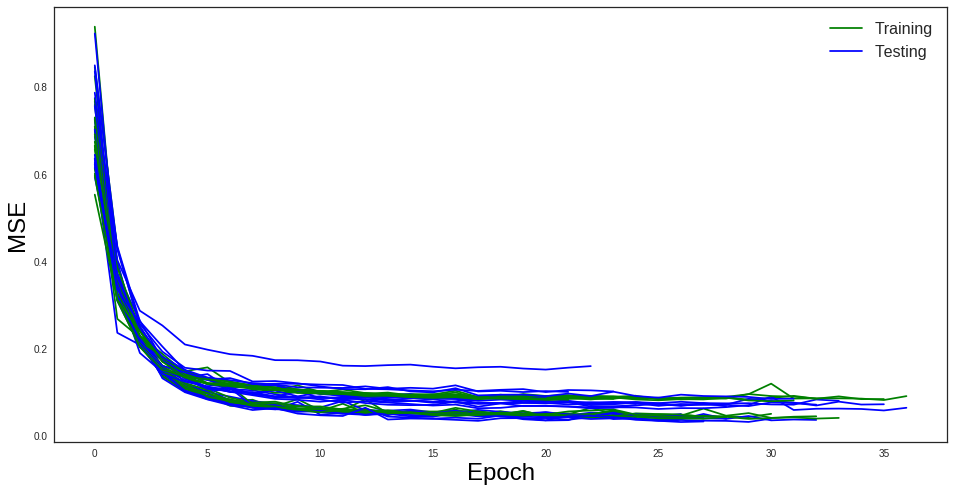

In [758]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [759]:
aresults = []
for j in range (0,2):
    with open('train_weights/resultsFile' + '_' + str(j) + '.pkl', 'r') as fin:   
        aresults.append(pickle.load(fin))

In [760]:
def loadModel(cycle, j, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '_'+ str(j) +'.h5')
    model.compile(**compileArgs[j])
    return model

In [761]:
def getWeights(value, met):
    return 1/value

In [762]:

weights = [[],[]]
ensemble = [[],[]]
print ("Choosing ensemble by", ensembleMode)
for j in range(0,2):
    #weights=[]
    #ensemble = []
    if ensembleMode == 'mix':
        for met in aresults[j][0]:
            print ("Choosing best for metric", met)
            cycle = np.argmin([aresult[j][met] for result in aresults[j]])
            print (met, "Model", "is", cycle, "with", met, "=", aresults[j][cycle][met])
            ensemble[j].append(loadModel(cycle) , j)
            weights[j].append(1)
    else:
        dtype = [('cycle', int), ('result', float)]
        values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(aresults[j])], dtype=dtype),
                         order=['result'])
        for i in range(min([ensembleSize, len(aresults[j])])):
            ensemble[j].append(loadModel(values[i]['cycle'], j))
            weights[j].append(getWeights(values[i]['result'], ensembleMode))
            print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
    weights[j] = np.array(weights[j])
    weights[j] = weights[j]/weights[j].sum() #normalise weights
    

Choosing ensemble by loss
Model 0 is 9 with loss = 0.0323625705733
Model 1 is 0 with loss = 0.0325912670496
Model 2 is 3 with loss = 0.0361924155583
Model 3 is 4 with loss = 0.0391054672372
Model 4 is 7 with loss = 0.0392731523494
Model 5 is 1 with loss = 0.0427490605739
Model 6 is 6 with loss = 0.0434229046509
Model 7 is 2 with loss = 0.0455613863627
Model 8 is 5 with loss = 0.0678532121552
Model 9 is 8 with loss = 0.0721238035407
Model 0 is 3 with loss = 0.0588633448207
Model 1 is 6 with loss = 0.0638388979073
Model 2 is 0 with loss = 0.068852923695
Model 3 is 4 with loss = 0.070268571678
Model 4 is 1 with loss = 0.0711583065175
Model 5 is 9 with loss = 0.0851739826235
Model 6 is 5 with loss = 0.0860230585208
Model 7 is 8 with loss = 0.101003361816
Model 8 is 7 with loss = 0.101075326631
Model 9 is 2 with loss = 0.15253127532


## Response of ensemble on development data

###  Preprocess data

In [763]:
X_dev0 = inputPipe[0].transform(devData[regTrainFeatures0].values.astype(theano.config.floatX))
X_dev1 = inputPipe[0].transform(devData[regTrainFeatures1].values.astype(theano.config.floatX))

### Get response

In [764]:
pred0 = np.zeros((len(devData), len(regTargetFeatures0)))
for i, model in enumerate(ensemble[0]):
    pred0 += weights[0][i]*outputPipe[0].inverse_transform(model.predict(X_dev0, verbose=0)) 
pred1 = np.zeros((len(devData), len(regTargetFeatures1)))
for i, model in enumerate(ensemble[1]):
    pred1 += weights[1][i]*outputPipe[1].inverse_transform(model.predict(X_dev1, verbose=0)) 

In [765]:
for n, feature in enumerate(regTargetFeatures0):
    devData['reg_' + feature[4:]] = pandas.Series(pred0[:,n], index=devData.index)
for n, feature in enumerate(regTargetFeatures1):
    devData['reg_' + feature[4:]] = pandas.Series(pred1[:,n], index=devData.index)
bMass = 4.8
devData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_0_px'])+np.square(devData.loc[:,'reg_b_0_py'])+np.square(devData.loc[:,'reg_b_0_pz']))
devData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_1_px'])+np.square(devData.loc[:,'reg_b_1_py'])+np.square(devData.loc[:,'reg_b_1_pz']))
devData['reg_h_bb_px'] = devData.loc[:,'reg_b_0_px']+devData.loc[:,'reg_b_1_px']
devData['reg_h_bb_py'] = devData.loc[:,'reg_b_0_py']+devData.loc[:,'reg_b_1_py']
devData['reg_h_bb_pz'] = devData.loc[:,'reg_b_0_pz']+devData.loc[:,'reg_b_1_pz']
devData['reg_h_bb_E'] = devData.loc[:,'reg_b_0_E']+devData.loc[:,'reg_b_1_E']
devData['reg_h_bb_p2'] = np.square(devData.loc[:,'reg_h_bb_px'])+np.square(devData.loc[:,'reg_h_bb_py'])+np.square(devData.loc[:,'reg_h_bb_pz'])
devData['reg_h_bb_mass'] = np.sqrt(np.square(devData.loc[:,'reg_h_bb_E'])-devData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [766]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[:, 'reg_' + feature[4:]]-devData.loc[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData[:]['reg_h_bb_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 1274.72955119, Mean = 122.100924049 +- 0.101648976252, sigma = 68.7741514065 +- 0.146499107863


## Response of ensemble on validation data

###  Preprocess data

In [ ]:
X_val0 = inputPipe[0].transform(valData[regTrainFeatures0].values.astype(theano.config.floatX))
X_val1 = inputPipe[1].transform(valData[regTrainFeatures1].values.astype(theano.config.floatX))

### Get response

In [ ]:
pred0 = np.zeros((len(valData), len(regTargetFeatures0)))
for i, model in enumerate(ensemble[0]):
    pred0 += weights[0][i]*outputPipe[0].inverse_transform(model.predict(X_val0, verbose=0)) 
pred1 = np.zeros((len(valData), len(regTargetFeatures1)))
for i, model in enumerate(ensemble[1]):
    pred1 += weights[1][i]*outputPipe[1].inverse_transform(model.predict(X_val1, verbose=0)) 

In [ ]:
for n, feature in enumerate(regTargetFeatures0):
    valData['reg_' + feature[4:]] = pandas.Series(pred0[:,n], index=valData.index)
for n, feature in enumerate(regTargetFeatures1):
    valData['reg_' + feature[4:]] = pandas.Series(pred1[:,n], index=valData.index)
bMass = 4.8
valData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_0_px'])+np.square(valData.loc[:,'reg_b_0_py'])+np.square(valData.loc[:,'reg_b_0_pz']))
valData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_1_px'])+np.square(valData.loc[:,'reg_b_1_py'])+np.square(valData.loc[:,'reg_b_1_pz']))
valData['reg_h_bb_px'] = valData.loc[:,'reg_b_0_px']+valData.loc[:,'reg_b_1_px']
valData['reg_h_bb_py'] = valData.loc[:,'reg_b_0_py']+valData.loc[:,'reg_b_1_py']
valData['reg_h_bb_pz'] = valData.loc[:,'reg_b_0_pz']+valData.loc[:,'reg_b_1_pz']
valData['reg_h_bb_E'] = valData.loc[:,'reg_b_0_E']+valData.loc[:,'reg_b_1_E']
valData['reg_h_bb_p2'] = np.square(valData.loc[:,'reg_h_bb_px'])+np.square(valData.loc[:,'reg_h_bb_py'])+np.square(valData.loc[:,'reg_h_bb_pz'])
valData['reg_h_bb_mass'] = np.sqrt(np.square(valData.loc[:,'reg_h_bb_E'])-valData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [ ]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'reg_' + feature[4:]]-valData.loc[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.loc[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

### Momentum distributions

In [ ]:
"""for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
  
    bootGen = []
    meanBootGen = []
    stdevBootGen = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature].values, len(valData[sig]), replace=True)
        meanBootGen.append(points.mean())
        stdevBootGen.append(points.std())
    meanGen = (np.mean(meanBootGen), np.std(meanBootGen)/math.sqrt(len(meanBootGen)))
    stdevGen = (np.mean(stdevBootGen), np.std(stdevBootGen)/math.sqrt(len(stdevBootGen)))
    sns.kdeplot(valData[sig][feature])
    bootRec = []
    meanBootRec = []
    stdevBootRec = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBootRec.append(points.mean())
        stdevBootRec.append(points.std())
    meanRec = (np.mean(meanBootRec), np.std(meanBootRec)/math.sqrt(len(meanBootRec)))
    stdevRec = (np.mean(stdevBootRec), np.std(stdevBootRec)/math.sqrt(len(stdevBootRec)))
    sns.kdeplot(valData[sig][feature[4:]])
    bootReg = []
    meanBootReg = []
    stdevBootReg = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBootReg.append(points.mean())
        stdevBootReg.append(points.std())
    meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
    stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
    sns.kdeplot(valData[sig]["reg_" + feature[4:]])
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

In [ ]:
"""for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg][feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg][feature[4:]].values, label='bkg reco')
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg]["reg_" + feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg]["reg_" + feature[4:]].values, label='bkg reg')
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig][feature[4:]].values, label='sig recon')
    boot = [];
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig]["reg_" + feature[4:]].values, label='sig reg')
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()"""

### Momentum pull distributions

In [ ]:
"""print ("\tFeature\tmean\t\t\t\t\t\tsigma")
for n, feature in enumerate(regTargetFeatures):
    plt.figure(figsize=(8, 6))
    
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig][feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal, label='reconstructed', gridsize=500)
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['reg_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
       
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal, label='regressed', gridsize=500)
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
    plt.xlim(-100,100)
plt.show()"""

### Two-sample Kolmogorov–Smirnov test

In [ ]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['reg_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))

### Higgs mass distribution

In [ ]:

bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(valData[sig]['h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
    
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {:.2f} +- {:.2f}, sigma = {:.2f} +- {:.2f}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

In [ ]:

plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'].values, label='signal regressed')
sns.kdeplot(data=valData[sig]['h_bb_mass'].values, label='signal reconstructed')
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [ ]:
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice((valData[sig]['reg_h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice((valData[sig]['h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

In [ ]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=(valData[sig]['reg_h_bb_mass'].values-125)/125, label='signal regressed')
sns.kdeplot(data=(valData[sig]['h_bb_mass'].values-125)/125, label='signal reconstructed')
plt.legend(fontsize=16)
plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'].values, label = 'signal')
sns.kdeplot(data=valData[sigMM]['reg_h_bb_mass'].values, label = 'signal (match)')
sns.kdeplot(data=valData[bkg]['reg_h_bb_mass'].values, label = 'background')

plt.legend(fontsize=16)

plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [ ]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.ix[bkg, 'h_bb_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[bkg, 'reg_h_bb_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sig, 'h_bb_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.ix[sig, 'reg_h_bb_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1}])

In [ ]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))

In [ ]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'reg_h_bb_mass'].values, label='signal regressed', color = 'blue')
sns.kdeplot(data=valData.loc[sig, 'h_bb_mass'].values, label='signal reconstructed', color = 'blue' , ls = 'dashed')

sns.kdeplot(data=valData.loc[bkg, 'reg_h_bb_mass'].values, label='background regressed', color = 'green' )
sns.kdeplot(data=valData.loc[bkg, 'h_bb_mass'].values, label='background reconstructed', color = 'green', ls = 'dashed')

plt.legend(fontsize=16)
plt.xlim(0,300)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### ROC Curve

In [ ]:
print ('Reg:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], -np.abs(125-valData.ix[sig|bkg, 'reg_h_bb_mass'])))
print ('Reco:', roc_auc_score(valData.ix[sig|bkg, 'gen_target'], -np.abs(125-valData.ix[sig|bkg, 'h_bb_mass'])))

In [ ]:
sns.distplot(-np.abs(125-valData.loc[sig, 'reg_h_bb_mass']), label='signal')
sns.distplot(-np.abs(125-valData.loc[bkg, 'reg_h_bb_mass']), label='bkg')
plt.legend()

## Classifier response

### Train

In [ ]:
classFeatures = ['b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 't_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'mPT_px', 'mPT_py', 'b_0_|p|', 'b_0_E', 'b_1_|p|', 'b_1_E', 't_0_|p|', 't_0_E', 't_1_|p|', 't_1_E', 'diH_mass', 'h_tt_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'h_bb_|p|', 'h_bb_E', 'h_tt_|p|', 'h_tt_E', 'hl_mT']

In [ ]:
recoFeatures = ['h_bb_mass']#, 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
#recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
recoFeatures = classFeatures + ['h_bb_mass']
recoClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
recoClass.fit(valData[recoFeatures], valData['gen_target'].values.astype('int'))

In [ ]:
%%time
regFeatures = ['reg_h_bb_mass']#, 'reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
#regFeatures = ['reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
regFeatures = classFeatures + ['reg_h_bb_mass']
regClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
regClass.fit(valData[regFeatures], valData['gen_target'].values.astype('int'))

### Test

In [ ]:
recoPred = recoClass.predict_proba(valData[recoFeatures])[:,1]

In [ ]:
regPred = regClass.predict_proba(valData[regFeatures])[:,1]

In [ ]:
recoAUC = roc_auc_score(valData['gen_target'].values, recoPred)
regAUC = roc_auc_score(valData['gen_target'].values, regPred)

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, recoPred)[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC), color='g')
plt.plot(*roc_curve(valData['gen_target'].values, regPred)[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC), color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

## Save/load

### Update this

In [ ]:
#name = "weights/NN_B_Regressor_SO_App_" + mode + "_"
print (name)

### Save

In [ ]:
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for j in range(0,2):
    for i, model in enumerate(ensemble[j]):
        json_string = model.to_json()
        open(name + '_' + str(i) + "_" + str(j) +'.json', 'w').write(json_string)
        model.save_weights(name + '_' + str(i) + "_" + str(j) + '.h5')
    with open(name  + str(j) + '_compile.json', 'w') as fout:
        json.dump(compileArgs[j], fout)
    with open(name  + str(j) +'_weights.pkl', 'w') as fout:
        pickle.dump(weights[j], fout)
    with open(name  + str(j) +'_inputPipe.pkl', 'w') as fout:
        pickle.dump(inputPipe[j], fout)
    with open(name  + str(j) + '_outputPipe.pkl', 'w') as fout:
        pickle.dump(outputPipe[j], fout)

### Load

In [ ]:
ensemble = [[],[]]
weights = [None,None]
inputPipe = [None,None]
outputPipe = [None,None]
compileArgs = [None,None]
for j in range(0,2):
    with open(name + str (j) +'_compile.json', 'r') as fin:
        compileArgs[j] = json.load(fin)
    for i in range(ensembleSize):
        model = model_from_json(open(name + '_' + str(i) + '_' + str (j) + '.json').read())
        model.load_weights(name + "_" + str(i) + "_" + str (j) + '.h5')
        model.compile(**compileArgs[j])
        ensemble[j].append(model)
    with open(name + str (j)+ '_weights.pkl', 'r') as fin:
        weights[j] = pickle.load(fin)
    with open(name + str (j)+ '_inputPipe.pkl', 'r') as fin:
        inputPipe[j] = pickle.load(fin)
    with open(name + str (j)+ '_outputPipe.pkl', 'r') as fin:
        outputPipe[j] = pickle.load(fin)